In [ ]:
import pandas as pd
from pandas_gbq import read_gbq
import matplotlib.pyplot as plt
from google.cloud import storage

def fetch_data(path):
  try:
    df = pd.read_parquet(path)
    print("Read parquet successful")
    print(df.count())

    df.columns = df.columns.str.lower()
    df.rename(columns={'corr_elev_depth_spark': 'corr_elev_depth',
                      'avg_depth_spark': 'avg_depth'},
              inplace=True)

    display(df.head())
  except Exception as e:
    print(f"Error reading data from BigQuery using pandas_gbq: {e}")

  return df

BUCKET_NAME = "bucket_name"
SURVEY_SUMMARY = "processed/survey_summary.parquet"
SURVEY_ANOMALY= "processed/depth_anomaly.parquet"


df_summary = fetch_data(f"gs://{BUCKET_NAME}/{SURVEY_SUMMARY}")
df_anomaly = fetch_data(f"gs://{BUCKET_NAME}/{SURVEY_ANOMALY}")

Read parquet successful
SURVEY_NAME      1435
VERTEX           1435
Avg_Depth        1435
Max_Elevation    1435
Depth_Rank       1435
dtype: int64


,survey_name,vertex,avg_depth,max_elevation,depth_rank
0,AusAEM1,6,52.683,878.900320,1
1,AusAEM1,30,51.746,868.714472,2
2,AusAEM1,10,51.510,885.690886,3
3,AusAEM1,4,50.652,877.202679,4
4,AusAEM1,1295,49.286,649.852899,5


Read parquet successful
VERTEX            2847
SURVEY_LINE       2847
longitude         2847
latitude          2847
depth             2847
cell_avg_depth    2847
cell_std_depth    2847
cell_points       2847
grid_x            2847
grid_y            2847
depth_anomaly     2847
dtype: int64


,vertex,survey_line,longitude,latitude,depth,cell_avg_depth,cell_std_depth,cell_points,grid_x,grid_y,depth_anomaly
0,17,2029001,138.605249,-20.183122,650.790,165.184,323.743,4,2497,77664,485.606
1,6,2029001,139.094116,-20.182584,650.962,166.792,322.803,4,3008,77671,484.170
2,10,2021002,138.869536,-18.718253,651.858,175.955,317.274,4,2753,79290,475.903
3,4,2023002,140.230123,-19.179539,644.327,172.139,314.793,4,4190,78791,472.188
4,14,2033001,138.998519,-20.909818,642.215,224.013,239.779,5,2918,76865,418.202


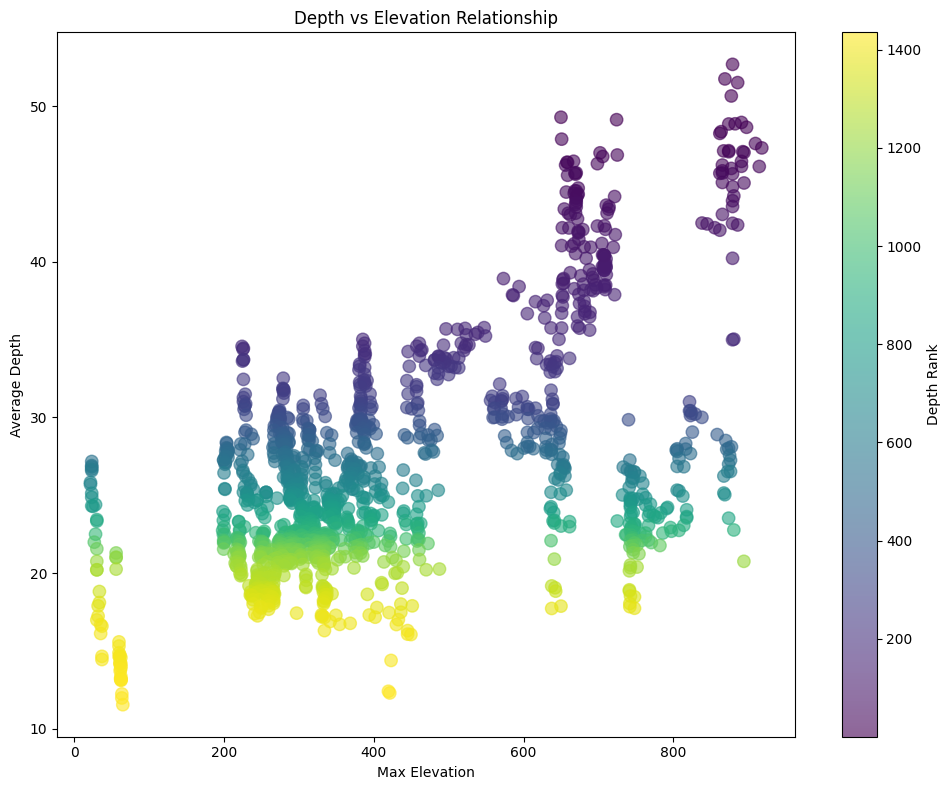

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'avg_depth' to numeric, handling potential errors by coercing to NaN
df_summary['avg_depth'] = pd.to_numeric(df_summary['avg_depth'], errors='coerce')

plt.figure(figsize=(10, 8))
# Scatter plot: Max Elevation vs Average Depth
plt.scatter(df_summary['max_elevation'], df_summary['avg_depth'], alpha=0.6, s=80, c=df_summary['depth_rank'], cmap='viridis')
plt.colorbar(label='Depth Rank')
plt.xlabel('Max Elevation')
plt.ylabel('Average Depth')
plt.title('Depth vs Elevation Relationship')

plt.tight_layout()
plt.show()

In [6]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 61.9 MB/s eta 0:00:00


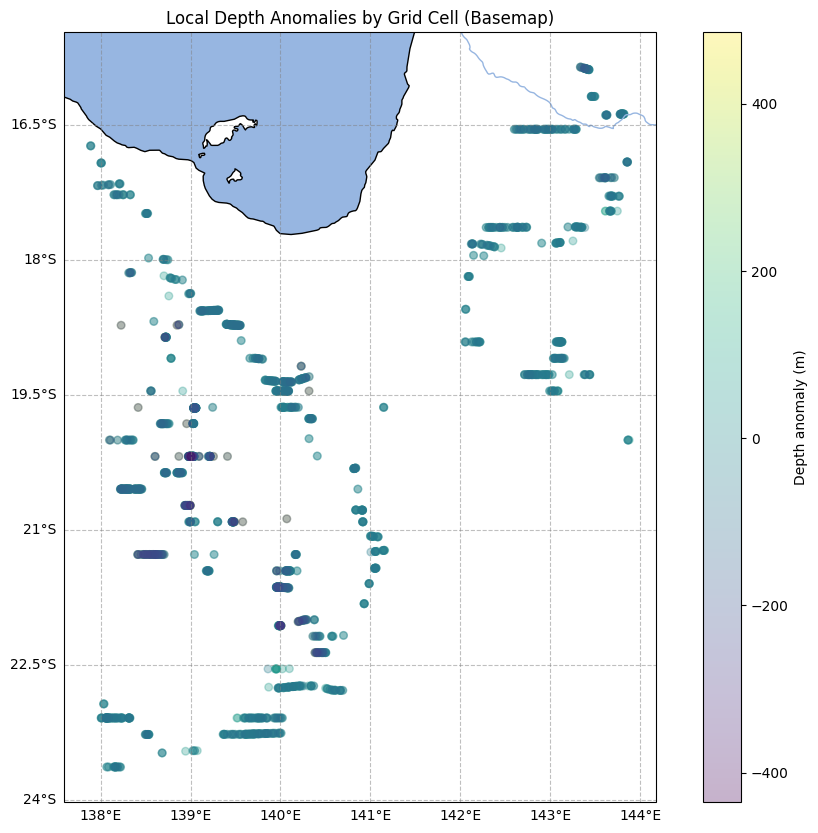

In [ ]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

sc = ax.scatter(
    df_anomaly["longitude"],
    df_anomaly["latitude"],
    c=df_anomaly["depth_anomaly"],
    cmap="viridis",
    alpha=0.3,
    s=30,
    transform=ccrs.PlateCarree()
)

plt.colorbar(sc, ax=ax, label="Depth anomaly (m)")
ax.set_title("Local Depth Anomalies by Grid Cell (Basemap)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()
